# Noised trajectories

In [1]:
import numpy as np
import numpy.random as alea
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

In [19]:
import pickle
import pandas as pd
record = pd.read_pickle('../2017_OptimalPrecision/DataRecording/dt_0.001/'+'HW_tau=0.013_dt=0.001_tT=0.062_tR=0.088_k=0.05_niter=5000_xT=21_v=10.0.pkl')

In [20]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [21]:
tau = 0.013
dt = 0.001 # step time
n = 2 # number of coordinates
k = 0.05

In [22]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt/tau
B[n-1] = dt

In [23]:
t_T = .062# saccade duration
t_R = .088 # pursuit duration
T = int(np.round(t_T/dt))
R = int(np.round(t_R/dt))
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.zeros(n) # starting point
xT = np.zeros(n) # ending point
xT[0] = 21
x0[0] = 0
#v = 10*np.cos(20*np.pi*time) # velocity of the target (deg/s)

In [24]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,n,n))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])

In [25]:
def state_vector(u, t):
    if t == 0:
        return x0
    else:
        w = np.zeros(len(u))
        for i in np.arange(t):
            w[i] = alea.normal(0,np.sqrt(k*(u[i])**2))
        return (ci[:,0:t]*np.flipud(u[0:t]+w[0:t])).sum(axis = 1)

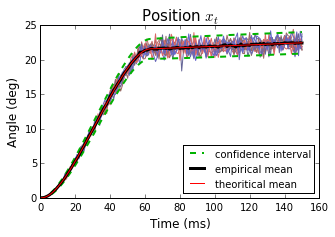

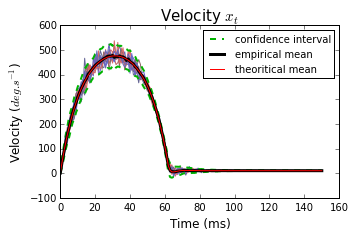

In [26]:
fig_width = 5
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ntest = 100
poss = np.zeros((ntest,T+R+1))
vels = np.zeros((ntest,T+R+1))

nshow = 10

col = np.zeros((nshow,3))
for i in np.arange(nshow):
    if i%2  == 0:
        col[i] = 1-alea.rand()/2, .4, .4
    else:
        col[i] = .4, .4, 1-alea.rand()/2

for j in np.arange(ntest):
    pos1 = np.zeros(T+R+1)
    pos2 = np.zeros(T+R+1)
    vel1 = np.zeros(T+R+1)
    vel2 = np.zeros(T+R+1)
    for i in np.arange(T+R+1):
        state_v = state_vector(record.signal[5000], i)
        pos1[i] = record.position[5000][i]
        pos2[i] = state_v[0]
        vel1[i] = record.velocity[5000][i]
        vel2[i] = state_v[1]
    poss[j, :] = pos2
    vels[j, :] = vel2
pos_mean = np.mean(poss, axis = 0)
vel_mean = np.mean(vels, axis = 0)
for j in np.arange(nshow):
    plt.figure(1)
    plt.plot(poss[j*ntest//nshow], color = col[j])

ecart_pos = np.zeros(T+R+1)
ecart_vel = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ecart_pos[i] = np.sqrt(np.var(poss[:,i]))
for i in np.arange(T+R+1):
    ecart_vel[i] = np.sqrt(np.var(vels[:,i]))
Iplus_pos = np.zeros(T+R+1)
Imoins_pos = np.zeros(T+R+1)
Iplus_vel = np.zeros(T+R+1)
Imoins_vel = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    Iplus_pos[i] = record.position[5000][i]+2*np.sqrt(record.variance[5000][i])
    Imoins_pos[i] = record.position[5000][i]-2*np.sqrt(record.variance[5000][i])
    Iplus_vel[i] = record.velocity[5000][i]+2*ecart_vel[i]
    Imoins_vel[i] = record.velocity[5000][i]-2*ecart_vel[i]
plt.plot(Iplus_pos, lw = 2, ls = '--', color =(0,0.7,0),label='confidence interval')
plt.plot(Imoins_pos, lw = 2, ls = '--', color =(0,0.7,0))
plt.plot(pos_mean, lw = 3, color ='black', label='empirical mean')
plt.plot(pos1, lw = 1, color ='red',label='theoritical mean')

ax.set_title(r'Position $x_t$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Angle (deg)', fontsize=12)
ax.legend(loc='lower right',prop={'size':10})
fig_width = 5
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

for j in np.arange(nshow):
    plt.figure(2)
    plt.plot(vels[j*ntest//nshow], color = col[j])

plt.plot(Iplus_vel, lw = 2, ls = '--', color =(0,0.7,0),label='confidence interval')
plt.plot(Imoins_vel, lw = 2, ls = '--', color =(0,0.7,0))
plt.plot(vel_mean, lw = 3, color = 'black', label='empirical mean')
plt.plot(vel1, lw = 1, color = 'red',label='theoritical mean')
ax.set_title(r'Velocity $x_t$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Velocity ($deg.s^{-1}$)', fontsize=12)
ax.legend(loc='upper right',prop={'size':10})

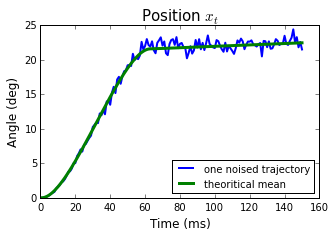

In [27]:
fig_width = 5
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(poss[0], lw=2,label='one noised trajectory')
ax.plot(pos1,lw=3,label='theoritical mean')
ax.set_title(r'Position $x_t$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Angle (deg)', fontsize=12)
ax.legend(loc='lower right',prop={'size':10})

(0, 100)

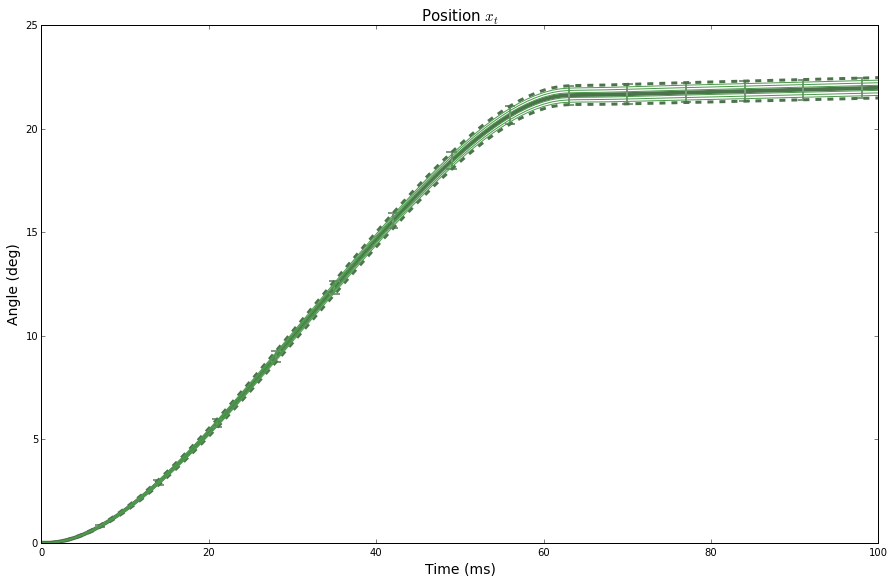

In [42]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ntest = 100
poss = np.zeros((ntest,T+R+1))

nshow = 10

for j in np.arange(ntest):
    pos1 = np.zeros(T+R+1)
    pos2 = np.zeros(T+R+1)

    for i in np.arange(T+R+1):
        state_v = state_vector(record.signal[5000], i)
        pos1[i] = record.position[5000][i]
        pos2[i] = state_v[0]

    poss[j, :] = pos2
pos_mean = np.mean(poss, axis = 0)

ecart_pos = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ecart_pos[i] = np.sqrt(np.var(poss[:,i]))

Iplus_pos = np.zeros(T+R+1)
Imoins_pos = np.zeros(T+R+1)
Iplus_pos2 = np.zeros(T+R+1)
Imoins_pos2 = np.zeros(T+R+1)
Iplus_pos3 = np.zeros(T+R+1)
Imoins_pos3 = np.zeros(T+R+1)
Iplus_pos4 = np.zeros(T+R+1)
Imoins_pos4 = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    Iplus_pos[i] = record.position[5000][i]+2*np.sqrt(record.variance[5000][i])
    Imoins_pos[i] = record.position[5000][i]-2*np.sqrt(record.variance[5000][i])
    Iplus_pos2[i] = record.position[5000][i]+np.sqrt(record.variance[5000][i])
    Imoins_pos2[i] = record.position[5000][i]-np.sqrt(record.variance[5000][i])
    Iplus_pos3[i] = record.position[5000][i]+.5*np.sqrt(record.variance[5000][i])
    Imoins_pos3[i] = record.position[5000][i]-.5*np.sqrt(record.variance[5000][i])
    Iplus_pos4[i] = record.position[5000][i]+1.5*np.sqrt(record.variance[5000][i])
    Imoins_pos4[i] = record.position[5000][i]-1.5*np.sqrt(record.variance[5000][i])
plt.plot(pos1, lw = 4, color = (0.3,0.45,0.3))

n_p = 20
for i in np.arange(n_p):
    plt.plot([(T+R)//n_p*i, (T+R)//n_p*i], [Iplus_pos[(T+R)//n_p*i], Imoins_pos[(T+R)//n_p*i]], lw = 2, marker = '_', color =(0.5,0.6,0.5))
    plt.plot([(T+R)//n_p*i-1/2, (T+R)//n_p*i+1/2], [Imoins_pos[(T+R)//n_p*i], Imoins_pos[(T+R)//n_p*i]], lw = 2, color =(0.5,0.6,0.5))
    plt.plot([(T+R)//n_p*i-1/2, (T+R)//n_p*i+1/2], [Iplus_pos[(T+R)//n_p*i], Iplus_pos[(T+R)//n_p*i]], lw = 2, color =(0.5,0.6,0.5))

plt.plot(Iplus_pos, ls = '--', lw = 3, color = (0.3,0.45,0.3))
plt.plot(Imoins_pos, ls = '--', lw = 3, color = (0.3,0.45,0.3))
plt.plot(Iplus_pos2, lw = 1, color = (0.3,0.6,0.3))
plt.plot(Imoins_pos2, lw = 1, color = (0.3,0.6,0.3))
plt.plot(Iplus_pos3, lw = 1, color = (0.3,0.6,0.3))
plt.plot(Imoins_pos3, lw = 1, color = (0.3,0.6,0.3))
plt.plot(Iplus_pos4, lw = 1, color = (0.3,0.6,0.3))
plt.plot(Imoins_pos4, lw = 1, color = (0.3,0.6,0.3))
ax.set_title(r'Position $x_t$', fontsize = 15)
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel('Angle (deg)', fontsize=14)
ax.set_xlim(-0, 100)


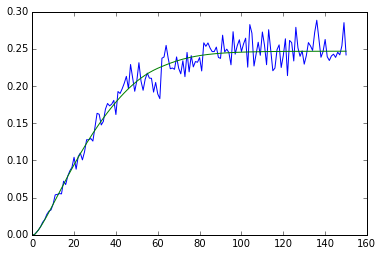

In [44]:
plt.plot(ecart_pos)
ecc = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    ecc[i] = np.sqrt(record.variance[5000][i])
plt.plot(ecc)

In [16]:
Iplus_pos 

array([  0.        ,   0.        ,   0.0456099 ,   0.12127214,
         0.22397968,   0.35068752,   0.50070301,   0.66832221,
         0.85678843,   1.05990192,   1.28034001,   1.51058644,
         1.75636837,   2.00621327,   2.27845939,   2.54128868,
         2.82145996,   3.1079339 ,   3.4101055 ,   3.70019904,
         4.00556288,   4.31079245,   4.61110619,   4.9218489 ,
         5.23262643,   5.5466274 ,   5.8518316 ,   6.15717067,
         6.46985603,   6.76377448,   7.07189615,   7.36546621,
         7.66536427,   7.95215908,   8.23890569,   8.50998773,
         8.76883732,   9.04400845,   9.29693751,   9.52472096,
         9.76695413,   9.99545924,  10.18998602,  10.3763155 ,
        10.54593749,  10.68988375,  10.83716491,  10.9538384 ,
        11.04406442,  11.12081569,  11.17068944,  11.1855902 ,
        11.19138905,  11.19073914,  11.2078266 ,  11.2139215 ,
        11.22273585,  11.2296464 ,  11.24508511,  11.2542101 ,
        11.26205797,  11.26561713,  11.26837111,  11.27

In [28]:
pos1

array([  0.        ,   0.        ,   0.02894949,   0.08453076,
         0.16459681,   0.26715757,   0.39036721,   0.53251222,
         0.69200051,   0.86735114,   1.05718486,   1.26021526,
         1.47524052,   1.70113572,   1.93684561,   2.18137785,
         2.43379667,   2.69321684,   2.95879802,   3.22973935,
         3.50527435,   3.78466596,   4.06720188,   4.35218992,
         4.63895364,   4.92682798,   5.21515498,   5.5032796 ,
         5.7905455 ,   6.07629082,   6.35984396,   6.64051928,
         6.91761268,   7.19039708,   7.45811781,   7.71998773,
         7.97518217,   8.22283369,   8.46202648,   8.69179053,
         8.91109535,   9.11884343,   9.31386317,   9.49490134,
         9.66061513,   9.80956346,   9.94019777,  10.0508521 ,
        10.13973242,  10.2049051 ,  10.24428452,  10.25561973,
        10.25878362,  10.26107149,  10.26445573,  10.2689705 ,
        10.27415697,  10.27959116,  10.28501442,  10.29031633,
        10.29548056,  10.30053602,  10.30552427,  10.31

In [69]:
u = np.zeros(T+R)

for i in np.arange(T+R-1):
    u[i] = ((pos1[i+2]-pos1[i+1])/dt-(1-dt/tau)*(pos1[i+1]-pos1[i])/dt)/dt

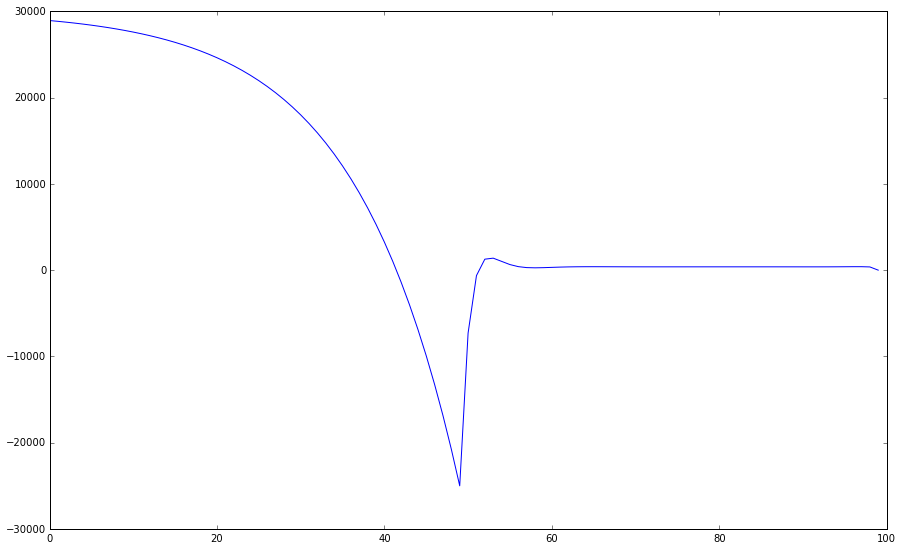

In [72]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(u)